In [ ]:
import os
import gensim
from gensim import corpora
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
from itertools import combinations
import collections
import json
import time
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from gensim.models import TfidfModel


In [ ]:
# 确保工作目录正确
os.chdir('/Users/jessie/Documents/Projects/Cusanus_Topic_Modeling')


In [ ]:
# 生成唯一实验ID
experiment_id = f"lda_experiment_{time.strftime('%Y%m%d%H%M%S')}"
experiment_dir = os.path.join('experiments', experiment_id)

# 创建实验目录
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

# 获取日志文件路径
log_file_path = os.path.join(experiment_dir, f"{experiment_id}.log")

# 配置日志记录
logger = logging.getLogger()
if logger.hasHandlers():
    logger.handlers.clear()
logger.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
file_handler = logging.FileHandler(log_file_path)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

logger.info(f"启动实验 {experiment_id}，日志记录到 {log_file_path}")
print(f"启动实验 {experiment_id}，日志记录到 {log_file_path}")


In [ ]:
# 加载测试集数据
testset_path = os.path.join('data', 'testset_paragraphs_level.json')
with open(testset_path, 'r', encoding='utf-8') as json_file:
    testset_data = json.load(json_file)

# 提取段落文本
documents = []
paragraph_contents = []
for document in testset_data["documents"]:
    for paragraph in document["paragraphs"]:
        documents.append(paragraph["content"].split())
        paragraph_contents.append(paragraph["content"])

logger.info(f"从测试集加载了 {len(documents)} 个段落")

In [ ]:
# 创建字典和语料库（用于 LDA）
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

logging.info("创建了 LDA 所需的词典和语料库")

print("词典大小：", len(dictionary))
print("语料库大小：", len(corpus))

In [ ]:
# 创建TF-IDF模型
tfidf = TfidfModel(corpus)  # corpus是包含所有文档的Bag-of-Words表示

# 计算每个词的平均TF-IDF值
word_tfidf = collections.defaultdict(float)
word_counts = collections.defaultdict(int)

for doc in corpus:
    tfidf_weights = tfidf[doc]
    for word_id, tfidf_value in tfidf_weights:
        word_tfidf[word_id] += tfidf_value
        word_counts[word_id] += 1

# 计算每个词的平均TF-IDF
average_tfidf = {word_id: total_tfidf / word_counts[word_id] for word_id, total_tfidf in word_tfidf.items()}

# 可视化 TF-IDF 分布
tfidf_values = list(average_tfidf.values())
plt.figure(figsize=(10, 6))
plt.hist(tfidf_values, bins=50, edgecolor='k')
plt.xlabel('TF-IDF 值')
plt.ylabel('词汇数量')
plt.title('词汇的 TF-IDF 分布')
plt.show()



In [ ]:
# 设置TF-IDF的阈值，选择低于此阈值的词作为通用词
tfidf_threshold = 0.2  # 你可以根据具体语料情况调整阈值
common_words = {dictionary[word_id] for word_id, avg_tfidf in average_tfidf.items() if avg_tfidf < tfidf_threshold}

# 保存已去除的通用词到文件
removed_common_words_path = os.path.join(experiment_dir, "removed_common_words_tfidf.txt")
with open(removed_common_words_path, "w", encoding="utf-8") as f:
    for word in common_words:
        f.write(word + "\n")

logger.info(f"已去除的通用词列表（基于TF-IDF）已保存到 {removed_common_words_path}")

# 过滤通用词，生成新的 `filtered_corpus`
filtered_corpus = [
    [(id, freq) for id, freq in doc if dictionary[id] not in common_words]
    for doc in corpus
]

# 更新字典以去除通用词
dictionary.filter_tokens(bad_ids=[dictionary.token2id[word] for word in common_words if word in dictionary.token2id])
dictionary.compactify()  # 确保字典的ID连续

# 重新生成语料库
filtered_corpus = [dictionary.doc2bow(text) for text in documents]

logger.info("基于TF-IDF的通用词过滤完成，生成新的语料库和字典")

print("词典大小：", len(dictionary))
print("语料库大小：", len(corpus))



In [ ]:
# 设置可能的 alpha 和 eta 值
alpha_values = [0.01, 0.05, 0.1]
eta_values = [0.01, 0.05, 0.1]

# 存储每次运行的结果
results = []

# 定义实验参数
num_topics = 10
passes = 50
iterations = 200

# 遍历 alpha 和 eta 的所有组合
for alpha in alpha_values:
    for eta in eta_values:
        # 训练 LDA 模型
        lda_model = gensim.models.LdaModel(
            corpus=filtered_corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=passes,
            iterations=iterations,
            alpha=alpha,
            eta=eta
        )

        # 计算主题一致性（NPMI）
        coherence_model_npmi = CoherenceModel(
            model=lda_model,
            texts=documents,  # 使用去除通用词后的文本
            dictionary=dictionary,
            coherence='c_npmi'
        )
        avg_npmi = coherence_model_npmi.get_coherence()

        # 计算主题多样性
        unique_words = set()
        total_words = 0
        for topic in lda_model.show_topics(num_topics=num_topics, num_words=20, formatted=False):
            words = [word for word, _ in topic[1]]
            unique_words.update(words)
            total_words += len(words)
        topic_diversity = len(unique_words) / total_words

        # 将结果存储到列表中
        results.append({
            'alpha': alpha,
            'eta': eta,
            'avg_npmi': float(avg_npmi),  # 转换为 float 类型
            'topic_diversity': float(topic_diversity)  # 转换为 float 类型
        })

        # 输出当前结果
        logger.info(f"Alpha: {alpha}, Eta: {eta}, Avg NPMI: {avg_npmi:.4f}, Topic Diversity: {topic_diversity:.2f}")

# 找到最优的组合参数
best_result = max(results, key=lambda x: (x['avg_npmi'], x['topic_diversity']))



Alpha: 0.01, Eta: 0.01, Avg NPMI: -0.4382, Topic Diversity: 0.89
Alpha: 0.01, Eta: 0.05, Avg NPMI: -0.4384, Topic Diversity: 0.90
Alpha: 0.01, Eta: 0.1, Avg NPMI: -0.4238, Topic Diversity: 0.88
Alpha: 0.05, Eta: 0.01, Avg NPMI: -0.4390, Topic Diversity: 0.90
Alpha: 0.05, Eta: 0.05, Avg NPMI: -0.4381, Topic Diversity: 0.91
Alpha: 0.05, Eta: 0.1, Avg NPMI: -0.4291, Topic Diversity: 0.86
Alpha: 0.1, Eta: 0.01, Avg NPMI: -0.4390, Topic Diversity: 0.89
Alpha: 0.1, Eta: 0.05, Avg NPMI: -0.4393, Topic Diversity: 0.88
Alpha: 0.1, Eta: 0.1, Avg NPMI: -0.4296, Topic Diversity: 0.87

最优结果: Alpha: 0.01, Eta: 0.1, Avg NPMI: -0.4238, Topic Diversity: 0.88


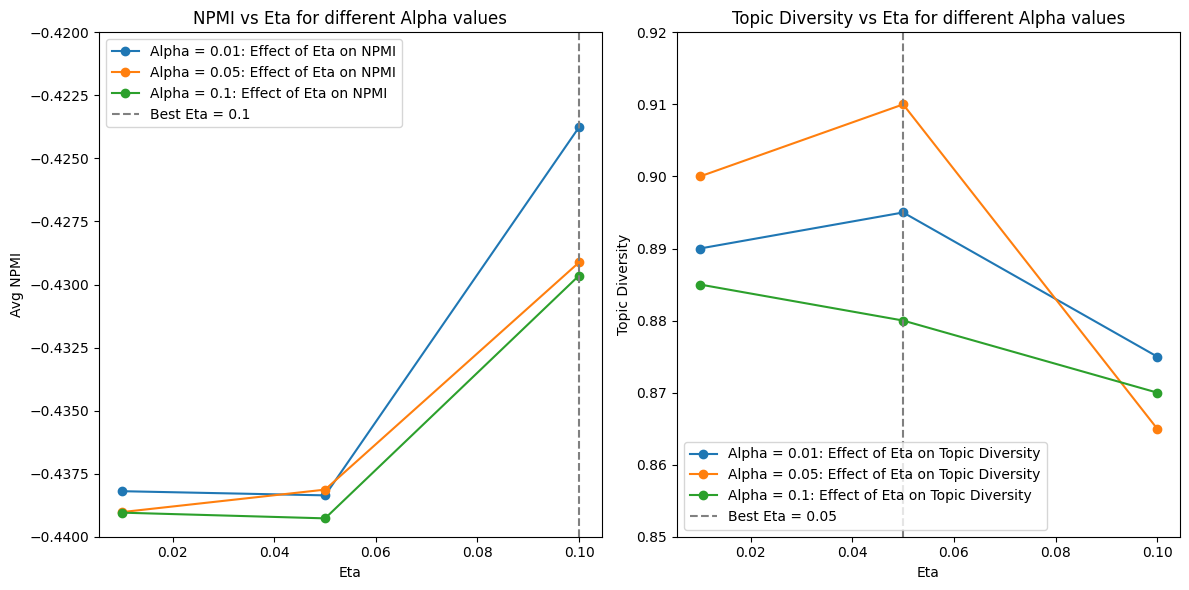

2024-11-10 23:04:02,990 - INFO - 图像已保存至 experiments/lda_experiment_20241110220945/LDA_NPMI_TopicDiversity_vs_Alpha_Eta.png


In [ ]:
# 输出所有组合的结果
for result in results:
    print(f"Alpha: {result['alpha']}, Eta: {result['eta']}, Avg NPMI: {result['avg_npmi']:.4f}, Topic Diversity: {result['topic_diversity']:.2f}")

# 输出最优结果
print(f"\n最优结果: Alpha: {best_result['alpha']}, Eta: {best_result['eta']}, Avg NPMI: {best_result['avg_npmi']:.4f}, Topic Diversity: {best_result['topic_diversity']:.2f}")

import matplotlib.pyplot as plt

# 提取 alpha 和 eta 值
alpha_values = [result['alpha'] for result in results]
eta_values = [result['eta'] for result in results]
avg_npmi_values = [result['avg_npmi'] for result in results]
topic_diversity_values = [result['topic_diversity'] for result in results]

# 找到 NPMI 和 Topic Diversity 的最佳超参数组合（假设 NPMI 越大越好，Diversity 越大越好）
best_npmi_result = max(results, key=lambda x: x['avg_npmi'])
best_diversity_result = max(results, key=lambda x: x['topic_diversity'])

# 绘制 NPMI 变化曲线
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for alpha in sorted(set(alpha_values)):
    alpha_npmi = [result['avg_npmi'] for result in results if result['alpha'] == alpha]
    eta_subset = [result['eta'] for result in results if result['alpha'] == alpha]
    plt.plot(eta_subset, alpha_npmi, marker='o', label=f'Alpha = {alpha}: Effect of Eta on NPMI')

# 标记最佳 NPMI 的垂直线
plt.axvline(best_npmi_result['eta'], color='gray', linestyle='--', label=f'Best Eta = {best_npmi_result["eta"]}')
plt.xlabel('Eta')
plt.ylabel('Avg NPMI')
plt.ylim([-0.440, -0.420])  # 设置 y 轴范围放大变化
plt.title('NPMI vs Eta for different Alpha values')
plt.legend()

# 绘制 Topic Diversity 变化曲线
plt.subplot(1, 2, 2)
for alpha in sorted(set(alpha_values)):
    alpha_diversity = [result['topic_diversity'] for result in results if result['alpha'] == alpha]
    eta_subset = [result['eta'] for result in results if result['alpha'] == alpha]
    plt.plot(eta_subset, alpha_diversity, marker='o', label=f'Alpha = {alpha}: Effect of Eta on Topic Diversity')

# 标记最佳 Topic Diversity 的垂直线
plt.axvline(best_diversity_result['eta'], color='gray', linestyle='--', label=f'Best Eta = {best_diversity_result["eta"]}')
plt.xlabel('Eta')
plt.ylabel('Topic Diversity')
plt.ylim([0.85, 0.92])  # 设置 y 轴范围放大变化
plt.title('Topic Diversity vs Eta for different Alpha values')
plt.legend()

plt.tight_layout()

image_path = os.path.join(experiment_dir, 'LDA_NPMI_TopicDiversity_vs_Alpha_Eta.png')
plt.savefig(image_path)
plt.show()

logger.info(f"图像已保存至 {image_path}")

In [ ]:
# 最优参数设置
params = {
    "num_topics": num_topics,
    "passes": passes,
    "iterations": iterations,
    "alpha": best_result['alpha'],
    "eta": best_result['eta'],
    "tfidf_threshold": tfidf_threshold  
}
params_path = os.path.join(experiment_dir, 'params.json')
with open(params_path, 'w') as f:
    json.dump(params, f, indent=4)
logger.info(f"最优参数设置已保存至 {params_path}")

lda_model = gensim.models.LdaModel(
    corpus=filtered_corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=passes,
    iterations=iterations,
    alpha=best_result['alpha'],
    eta=best_result['eta']
)


In [ ]:
# 获取每个主题的关键词
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)
topic_keywords = {topic_id: [word for word, _ in words] for topic_id, words in topics}

# 保存主题词和评估结果到一个文件
results_file_path = os.path.join(experiment_dir, 'lda_results.txt')
with open(results_file_path, 'w', encoding='utf-8') as f:
    # 保存主题词
    f.write("LDA 生成的主题：\n")
    for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
        topic_str = f"Topic {idx}: {topic}"
        f.write(topic_str + '\n')
    f.write("\n")

    # 保存评估结果
    f.write(f"困惑度: {lda_model.log_perplexity(filtered_corpus)}\n")
    f.write(f"主题一致性 (NPMI): {best_result['avg_npmi']}\n")
    f.write(f"主题多样性: {best_result['topic_diversity']}\n")

logger.info(f"主题词和评估结果已保存至 {results_file_path}")

In [ ]:
# 保存文档的主题分配情况
doc_topic_distributions = []
for i, doc in enumerate(filtered_corpus):
    doc_topics = lda_model.get_document_topics(doc)
    
    # 计算当前文档和段落索引
    doc_index = 0
    para_index = i
    while para_index >= len(testset_data["documents"][doc_index]["paragraphs"]):
        para_index -= len(testset_data["documents"][doc_index]["paragraphs"])
        doc_index += 1
    
    # 获取当前的文档ID和段落编号
    document_id = testset_data["documents"][doc_index]["document_id"]
    paragraph_num = para_index
    paragraph_content = testset_data["documents"][doc_index]["paragraphs"][paragraph_num]["content"]
    
    if paragraph_content:
        for topic_id, prob in doc_topics:
            doc_topic_distributions.append({
                "Document": document_id,
                "Paragraph": paragraph_num,
                "Content": paragraph_content,
                "Topic": topic_id,
                "Topic Keywords": topic_keywords[topic_id],  # 添加主题关键词
                "Probability": float(prob)
            })

In [ ]:
# 保存文档的主题分配情况到 CSV 文件
csv_output_path = os.path.join(experiment_dir, 'document_topic_distributions.csv')
topic_distributions_df = pd.DataFrame(doc_topic_distributions)
topic_distributions_df.to_csv(csv_output_path, index=False)
logger.info(f"文档的主题分配情况已保存至: {csv_output_path}")

# 保存文档的主题分配情况到 JSON 文件
json_output_path = os.path.join(experiment_dir, 'document_topic_distributions.json')
with open(json_output_path, 'w', encoding='utf-8') as json_file:
    json.dump(doc_topic_distributions, json_file, ensure_ascii=False, indent=4)
logger.info(f"文档的主题分配情况已保存至: {json_output_path}")

# 保存 pyLDAvis 可视化
lda_visualization = gensimvis.prepare(lda_model, filtered_corpus, dictionary, n_jobs=1)
pyldavis_path = os.path.join(experiment_dir, 'lda_visualization.html')
pyLDAvis.save_html(lda_visualization, pyldavis_path)
logger.info(f"pyLDAvis 可视化已保存至: {pyldavis_path}")

print(f"\n最优结果已保存到: {experiment_dir}")